In [459]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
rcParams['figure.figsize'] = 15, 7

In [460]:
data = pd.read_csv('ProductA_Sales.csv')
data.head()

,Month,Product_A,Product
0,2011-01-01,0.00%,0.001960
1,2011-02-01,0.03%,0.032618
2,2011-03-01,0.10%,0.095821
3,2011-04-01,0.16%,0.162252
4,2011-05-01,0.23%,0.227217


In [461]:
#Convert date to datetime format for simplicity
data['Month']=pd.to_datetime(data['Month'],infer_datetime_format=True)
data.set_index(['Month'],inplace=True)

In [462]:
data.head()

,Product_A,Product
Month,,
2011-01-01,0.00%,0.001960
2011-02-01,0.03%,0.032618
2011-03-01,0.10%,0.095821
2011-04-01,0.16%,0.162252
2011-05-01,0.23%,0.227217


In [463]:
data.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01',
               ...
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01'],
              dtype='datetime64[ns]', name='Month', length=102, freq=None)

In [464]:
#Convery data into timeseries(ts)
ts= data['Product']
ts.head(10)

Month
2011-01-01    0.001960
2011-02-01    0.032618
2011-03-01    0.095821
2011-04-01    0.162252
2011-05-01    0.227217
2011-06-01    0.317669
2011-07-01    0.361898
2011-08-01    0.411029
2011-09-01    0.483340
2011-10-01    0.552514
Name: Product, dtype: float64

# **Checking for stationarity**

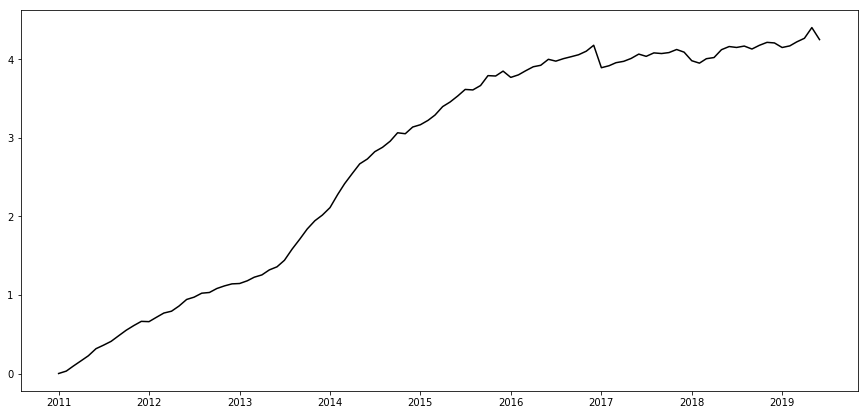

In [465]:
plt.plot(ts, color='black')

The above plot displays an upward trend with varying mean. Hence we can say that the data is not stationary.                            

# **Proof of Stationarity**

## **Rolling Statistics Method:**

In [466]:
def rolling_stationarity(timeseries):
    rolling_mean = timeseries.rolling(window=12,center=False).mean()
    rolling_std = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    original = plt.plot(timeseries, color='black',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std_dev = plt.plot(rolling_std, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

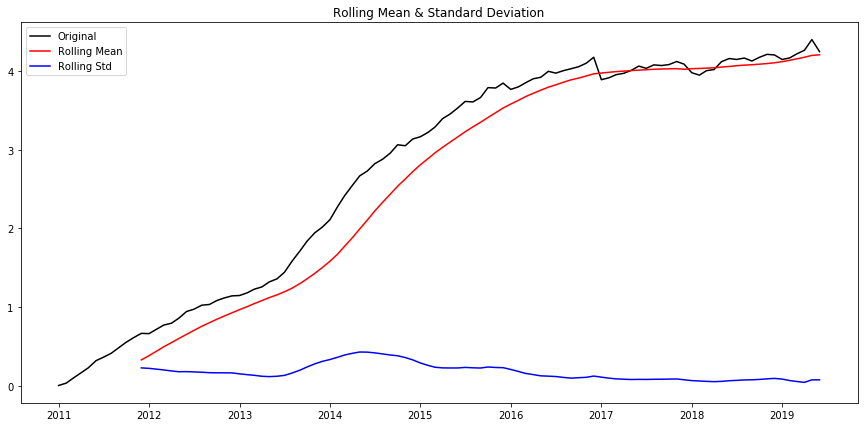

In [467]:
rolling_stationarity(ts)

The above graph clearly displays that both mean and standard deviation are varying. However, for evidence we will use Dickey-Fuller Method.

## **Dickey-Fuller Method:**

In [468]:
def dickeyfuller_stationarity(timeseries):
    print ('Results of Dickey-Fuller Method:')
    df_method = adfuller(timeseries, autolag='AIC')
    df_result = pd.Series(df_method[0:4], index=['Test Stat','p-value','Number of Lags','Number of Observations'])
    for key,value in df_method[4].items():
        df_result['Critical Value (%s)'%key] = value
    print(df_result)

In [469]:
dickeyfuller_stationarity(ts)

Results of Dickey-Fuller Method:
Test Stat                 -1.869767
p-value                    0.346415
Number of Lags            13.000000
Number of Observations    88.000000
Critical Value (1%)       -3.506944
Critical Value (5%)       -2.894990
Critical Value (10%)      -2.584615
dtype: float64


Through the results obtained from Dickey-Fuller Method, p-value is 0.34. And, as our p-value is way above 0.05 we cannot reject the Null Hypothesis. In addition, Test Stat is greater than critical value supporting the non-sationarity of the data.

# **Changing Time Series to Stationary**

## **Smoothing:**

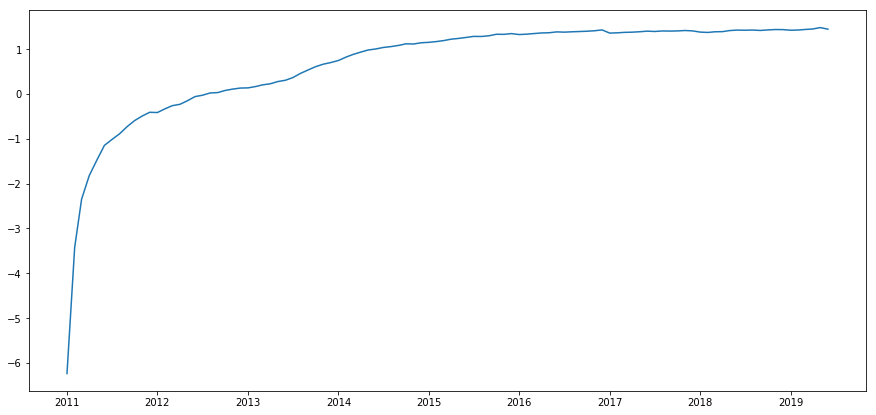

In [470]:
#estimate trends using log function
ts_log = np.log(ts)
plt.plot(ts_log)

It can be seen from the plot that the trend has changed a bit but to get it more stationary we need to do more smoothing

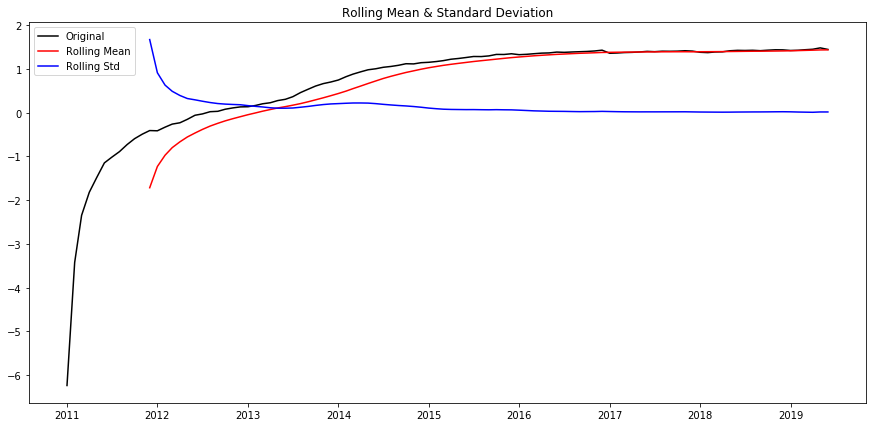

Results of Dickey-Fuller Method:
Test Stat                 -2.071545
p-value                    0.256109
Number of Lags            13.000000
Number of Observations    88.000000
Critical Value (1%)       -3.506944
Critical Value (5%)       -2.894990
Critical Value (10%)      -2.584615
dtype: float64


In [471]:
rolling_stationarity(ts_log)
dickeyfuller_stationarity(ts_log)

### Exponentially Weighted Moving Average

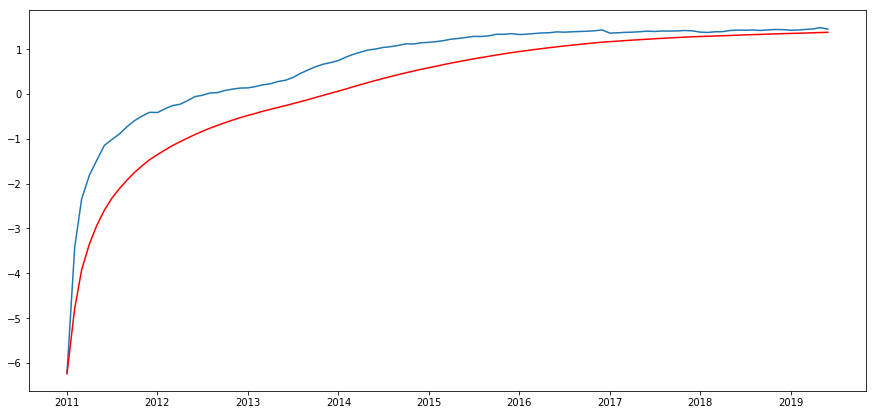

In [472]:
#use the exponential weighted moving average with a window size of 12 (yearly)
expweighted_avg = ts_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

After running exponential weight moving average, we can see an upward trend. Further, as timeseries progresses weighted mean progresses too.

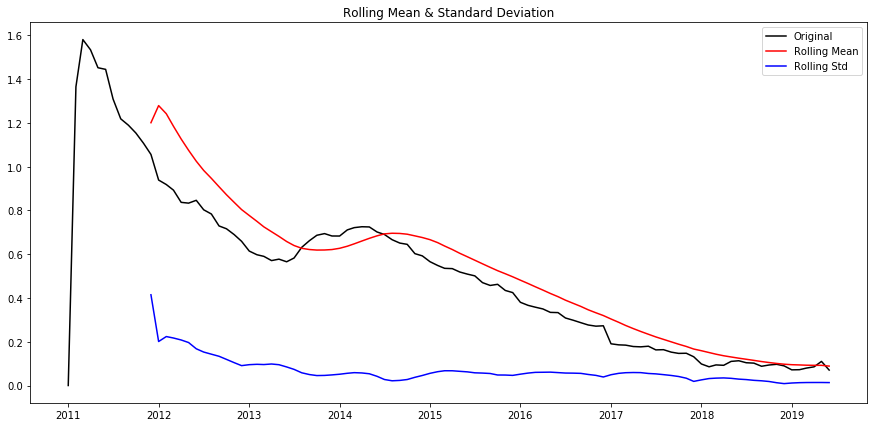

Results of Dickey-Fuller Method:
Test Stat                 -0.559130
p-value                    0.879952
Number of Lags            13.000000
Number of Observations    88.000000
Critical Value (1%)       -3.506944
Critical Value (5%)       -2.894990
Critical Value (10%)      -2.584615
dtype: float64


In [473]:
#perform the transformation for getting the data stationary
ts_ewma_diff = ts_log - expweighted_avg
rolling_stationarity(ts_ewma_diff)
dickeyfuller_stationarity(ts_ewma_diff)

Perform Exponential weight moving average as long as the p-value is reduced to atleast 0.05

### Exp2

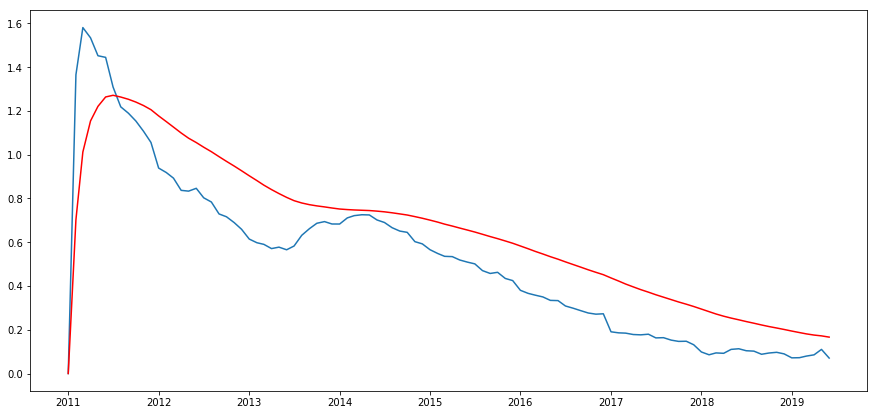

In [474]:
expweighted_avg1 = ts_ewma_diff.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(ts_ewma_diff)
plt.plot(expweighted_avg1, color='red')

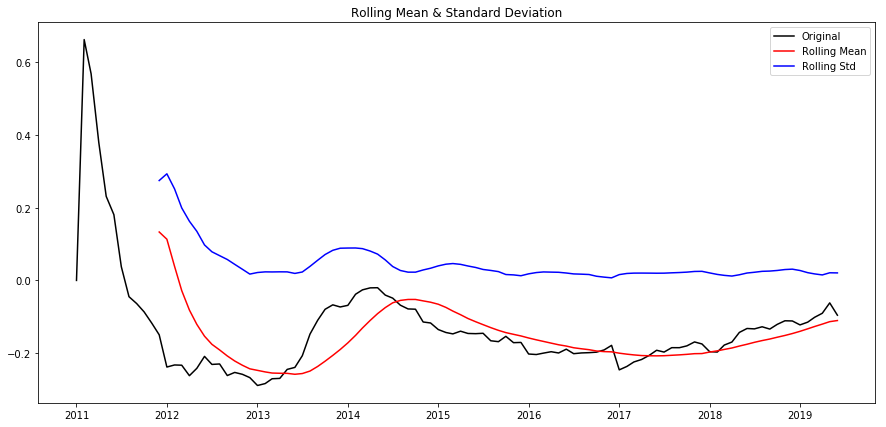

Results of Dickey-Fuller Method:
Test Stat                 -2.759760
p-value                    0.064256
Number of Lags            12.000000
Number of Observations    89.000000
Critical Value (1%)       -3.506057
Critical Value (5%)       -2.894607
Critical Value (10%)      -2.584410
dtype: float64


In [475]:
ts_ewma_diff1 = ts_ewma_diff - expweighted_avg1
rolling_stationarity(ts_ewma_diff1)
dickeyfuller_stationarity(ts_ewma_diff1)

### Exp 3

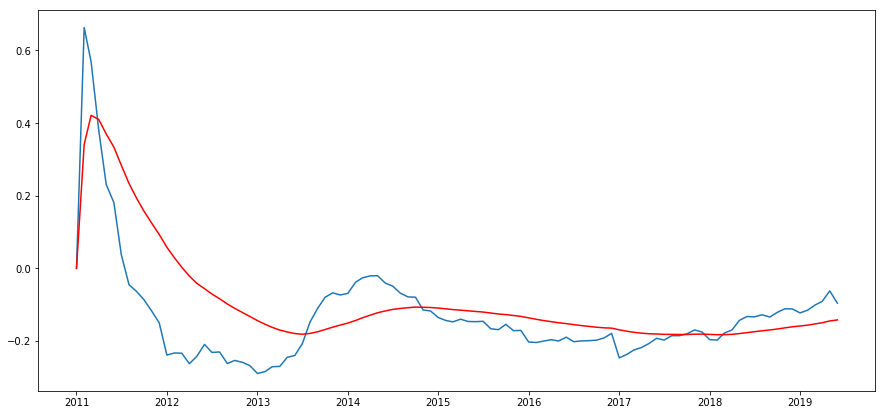

In [476]:
expweighted_avg2 = ts_ewma_diff1.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(ts_ewma_diff1)
plt.plot(expweighted_avg2, color='red')

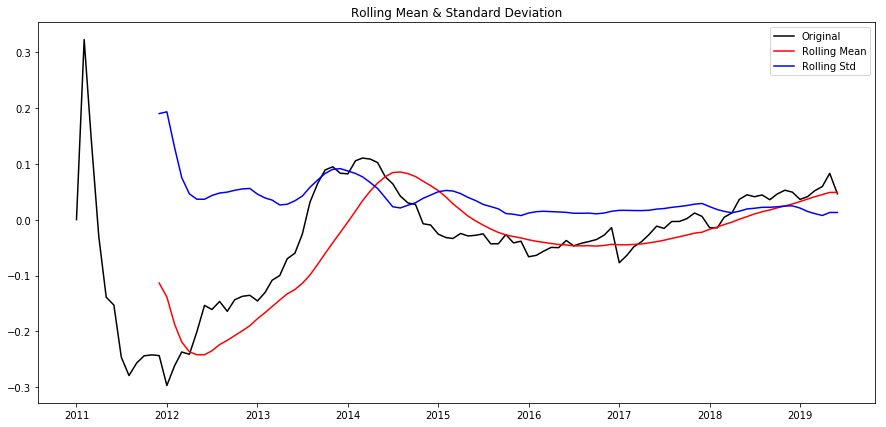

Results of Dickey-Fuller Method:
Test Stat                 -2.854646
p-value                    0.050882
Number of Lags            12.000000
Number of Observations    89.000000
Critical Value (1%)       -3.506057
Critical Value (5%)       -2.894607
Critical Value (10%)      -2.584410
dtype: float64


In [477]:
ts_ewma_diff2 = ts_ewma_diff1 - expweighted_avg2
rolling_stationarity(ts_ewma_diff2)
dickeyfuller_stationarity(ts_ewma_diff2)

### Exp 4

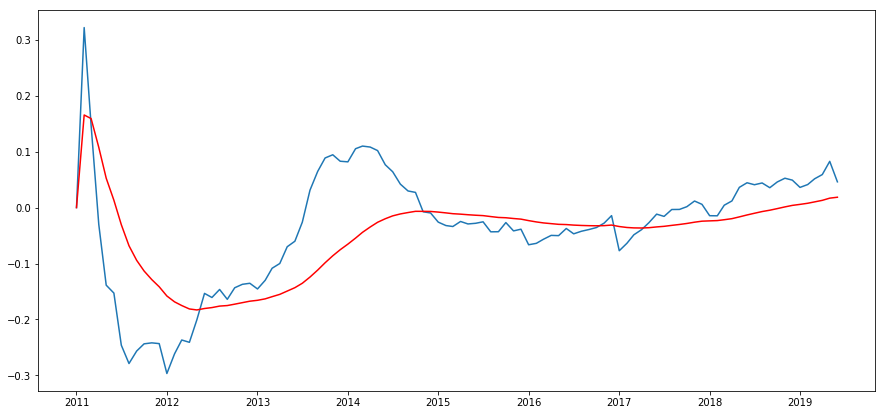

In [478]:
expweighted_avg3 = ts_ewma_diff2.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(ts_ewma_diff2)
plt.plot(expweighted_avg3, color='red')

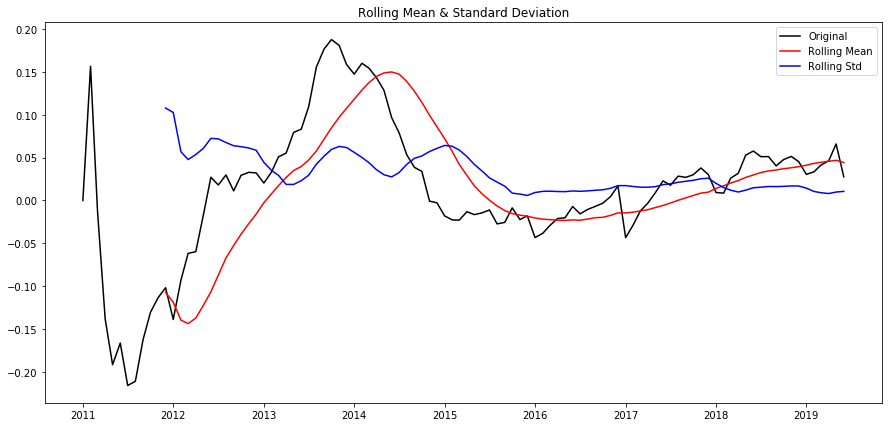

Results of Dickey-Fuller Method:
Test Stat                 -2.966336
p-value                    0.038160
Number of Lags            12.000000
Number of Observations    89.000000
Critical Value (1%)       -3.506057
Critical Value (5%)       -2.894607
Critical Value (10%)      -2.584410
dtype: float64


In [479]:
ts_ewma_diff3 = ts_ewma_diff2 - expweighted_avg3
rolling_stationarity(ts_ewma_diff3)
dickeyfuller_stationarity(ts_ewma_diff3)

Finally, after performing the exponential weighted average smoothing we get p-value < 0.05 and test-statistic less than critical value at 5 & 10% making the data STATIONARY.

### Original, Trend, Seasonal and Residuals of the data

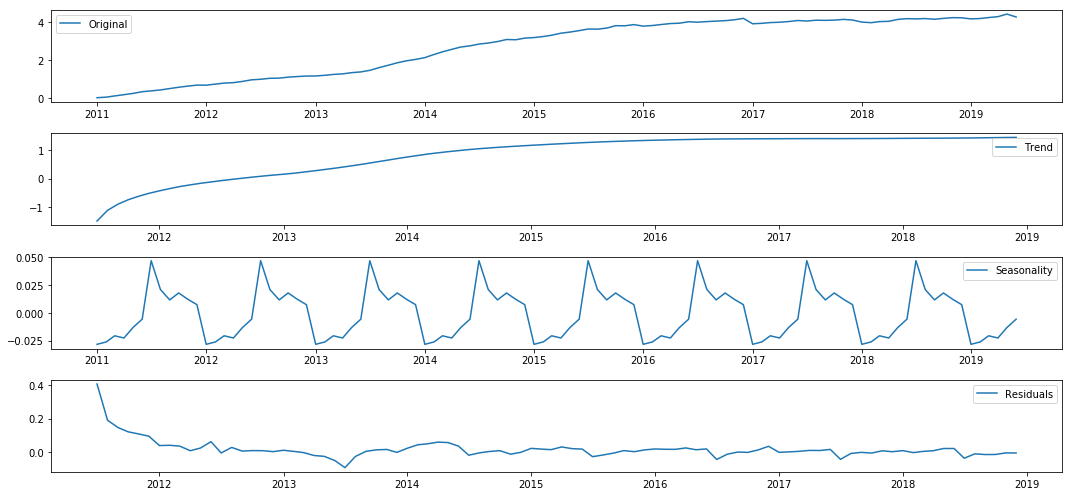

In [482]:
decompose = seasonal_decompose(ts_log)
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# **Final Forecasting**

## **AR Model**

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'AR model vs Exponentially weighted average')

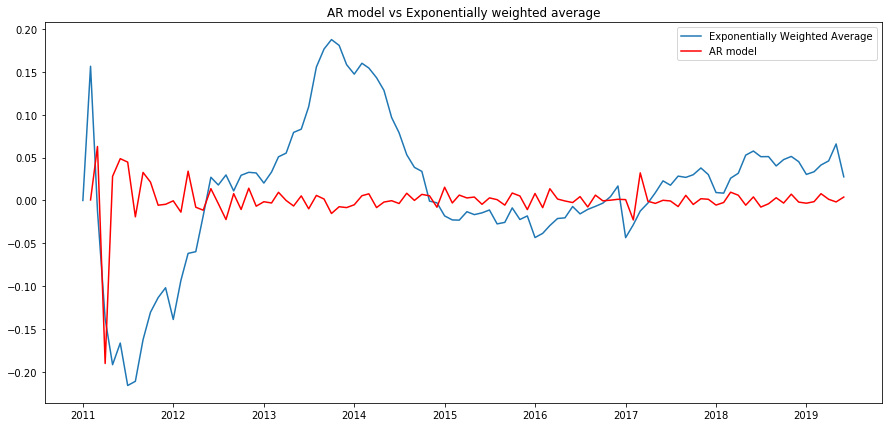

In [488]:
#AR model:
model = ARIMA(ts_ewma_diff2, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_ewma_diff3, label='Exponentially Weighted Average')
plt.legend(loc='best')
plt.plot(results_AR.fittedvalues, color='red', label='AR model')
plt.legend(loc='best')
plt.title('AR model vs Exponentially weighted average')

## **MA Model**

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'MA model vs Exponentially weighted average')

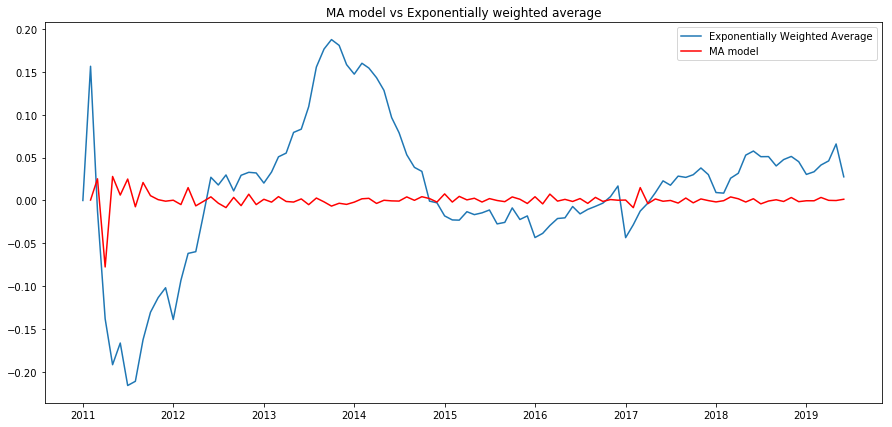

In [490]:
model = ARIMA(ts_ewma_diff2, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_ewma_diff3, label='Exponentially Weighted Average')
plt.legend(loc='best')
plt.plot(results_MA.fittedvalues, color='red', label='MA model')
plt.legend(loc='best')
plt.title('MA model vs Exponentially weighted average')

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'ARIMA model vs Exponentially weighted average')

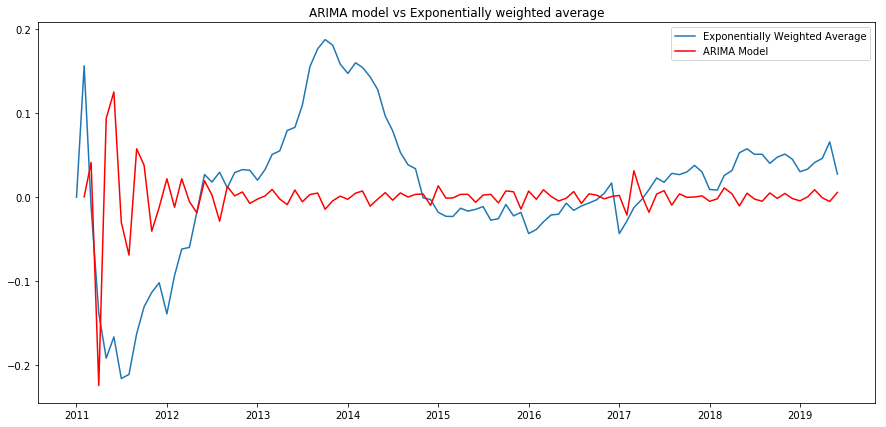

In [491]:
model = ARIMA(ts_ewma_diff2, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_ewma_diff3, label='Exponentially Weighted Average')
plt.legend(loc='best')
plt.plot(results_ARIMA.fittedvalues, color='red', label='ARIMA Model')
plt.legend(loc='best')
plt.title('ARIMA model vs Exponentially weighted average')

# **Original Scale Conversion**

In [492]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
2011-02-01    0.000485
2011-03-01    0.041298
2011-04-01   -0.223813
2011-05-01    0.093817
2011-06-01    0.125096
dtype: float64


In [493]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
2011-02-01    0.000485
2011-03-01    0.041782
2011-04-01   -0.182031
2011-05-01   -0.088214
2011-06-01    0.036882
dtype: float64


In [494]:
ts_log.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01',
               ...
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01'],
              dtype='datetime64[ns]', name='Month', length=102, freq=None)

In [506]:
ts.ix[0]

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


0.001959631

In [507]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
2011-01-01   -6.234999
2011-02-01   -6.234514
2011-03-01   -6.193217
2011-04-01   -6.417030
2011-05-01   -6.323213
dtype: float64

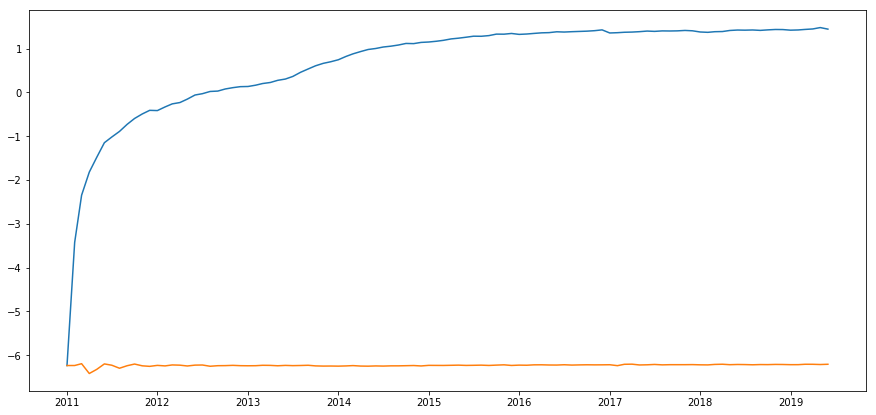

In [508]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

2.732903814725491


Text(0.5, 1.0, 'RMSE: 3.089810')

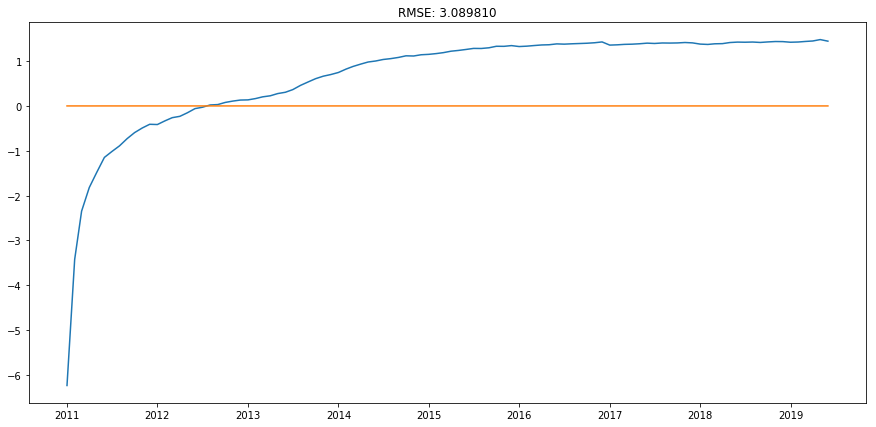

In [509]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(ts.mean())
plt.plot(ts_log)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

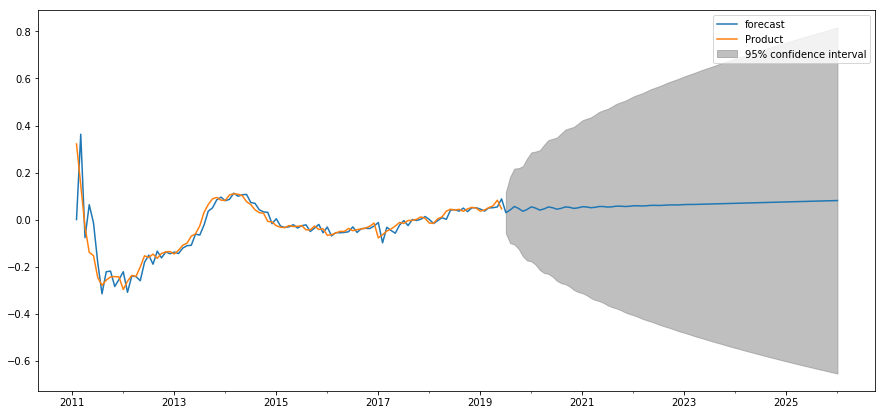

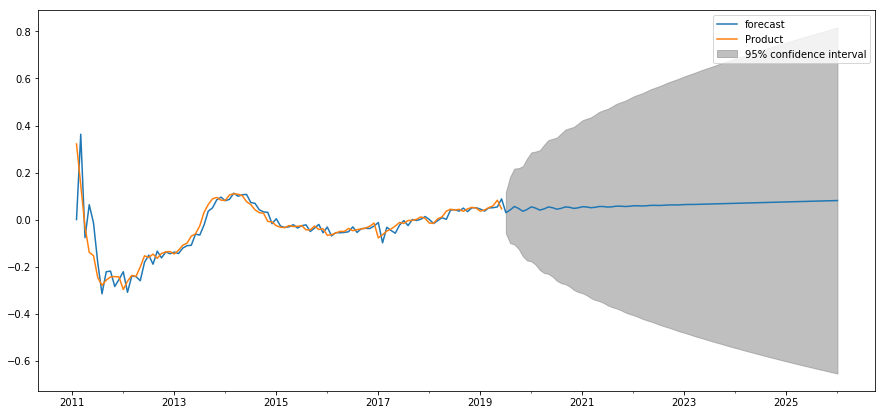

In [510]:
results_ARIMA.plot_predict(1,180)

In [500]:
x=results_ARIMA.forecast(steps=120)
x[1:10]

(array([0.04465891, 0.07179446, 0.0822018 , 0.08746224, 0.09759967,
        0.11069426, 0.11806964, 0.12266821, 0.12982642, 0.13888378,
        0.14500399, 0.14934177, 0.15515139, 0.16218448, 0.1675387 ,
        0.17168611, 0.17670593, 0.18252851, 0.18733954, 0.19131278,
        0.19580662, 0.20083307, 0.20522926, 0.20903494, 0.21314866,
        0.21761715, 0.22168281, 0.22532749, 0.22915011, 0.23320844,
        0.23700343, 0.24049525, 0.24408508, 0.24783007, 0.25139899,
        0.25474735, 0.2581448 , 0.26164257, 0.26501968, 0.26823462,
        0.27146898, 0.27476624, 0.27797853, 0.2810701 , 0.28416346,
        0.28729422, 0.29036323, 0.29334116, 0.29631073, 0.29930037,
        0.3022436 , 0.30511704, 0.30797657, 0.31084453, 0.31367631,
        0.31645372, 0.31921449, 0.32197594, 0.32470819, 0.32739728,
        0.33006871, 0.33273574, 0.33537842, 0.33798618, 0.34057624,
        0.34315869, 0.34572024, 0.34825296, 0.35076851, 0.35327448,
        0.35576209, 0.35822544, 0.3606724 , 0.36